<a href="https://colab.research.google.com/github/DiegoMejiaLLeras/Diplomado_Inteligencia_Artificial/blob/main/Proyecto_Diplomado_Clasificacion_imagenes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto Diplomado Inteligencia Artificial y Aprendizaje Profundo

**Integrantes**: 

Miguel E Robayo

Diego Mejía Lleras

Edison Vargas Buitrago

# Problema

El ejercicio realizado tiene como objetivo construir una máquina de clasificación de imágenes. Se dispone de un dataset de 60.176 imágenes clasificadas en 12 etiquetas, correspondientes a instancias de distintos tipos de interacción física entre individuos: golpear, correr, inactivo, patear, luchar, agruparse, caminar, abofetear, puñetazo, empujar, "dar los cinco", apalear. Todas las imágenes se encuentran en formato rgb con una dimensión de 614 x 811 pixeles. La fuente de los datos es: [*CHU SURVEILLANCE VIOLENCE DETECTION DATASET*](https://ieee-dataport.org/documents/chu-surveillance-violence-detection-dataset)

Se probaron dos estrategias de modelación:

1) Red convolucional entrenada totalmente sobre los datos iniciales.

2) Transfer Learning con 2 redes preentrenadas: VGG16 y RESNET.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importación de librerias 

Importamos las librerías necesarias

In [ ]:
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from google.colab import drive
drive.mount('/content/gdrive')
import os
import pickle
import tensorflow as tf
import cv2


Mounted at /content/gdrive


# Procesamiento.

Se realiza la canalización de entrada de las imágenes utilizando tf.data. La fuente de referencia es el tutorial de tensorflow [*Cargar Imágenes*](https://www.tensorflow.org/tutorials/load_data/images) 

Probamos si la gpu esta activa

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Rutas de archivo del zip que descargamos anteriormente. Decidimos cargarlo al Drive de manera descomprimida. En su defecto se puede usar la librería zipfiles.

In [ ]:
data_dir = '/content/gdrive/MyDrive/Colaboratory/CSVD/rgb'   
data_dir = pathlib.Path(data_dir)

Contamos las imágenes de los archivos disponibles en la ruta preespecificada. El árbol de la ruta es:

"/rgb/nombre_accion/img/archivo.jpg"

In [ ]:
image_count = len(list(data_dir.glob('*/*/*.jpg')))    

# primer * Busca en la carpeta "nombre_acción", segundo * busca la carpeta img y el tercer * busca cada imagen que termine con .jpg 
image_count

60176

Entubamiento de los datos:

In [ ]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/img/*'), shuffle=False)   
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

Verificación de algunos elementos al azar que están continidos en list_ds

In [ ]:
for f in list_ds.take(5):
  print(f.numpy())

b'/content/gdrive/MyDrive/Colaboratory/CSVD/rgb/kick/img/kick-0009-frame524.jpg'
b'/content/gdrive/MyDrive/Colaboratory/CSVD/rgb/run/img/run-0007-frame1084_Xv0o0XUinn.jpg'
b'/content/gdrive/MyDrive/Colaboratory/CSVD/rgb/slap/img/slap-0001-frame1360_3YRuE5JBIl.jpg'
b'/content/gdrive/MyDrive/Colaboratory/CSVD/rgb/shove/img/shove-0014-frame772_gevwjM5DWt.jpg'
b'/content/gdrive/MyDrive/Colaboratory/CSVD/rgb/grapple/img/grapple-0005-frame632.jpg'


Establecemos parámetros de tamáño de la imágen y de batch

In [ ]:
batch_size=128
img_height = 128
img_width = 128

Revisamos las clases disponibles, estas clasificaciones se encuentran dentro del archivo CSVD. El código busca cada nombre de la carpeta y excluye el archivo con el nombre "meta.json"

In [ ]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "meta.json"]))
print(class_names)

['club' 'grapple' 'highfive' 'idle' 'kick' 'pose' 'punch' 'run' 'shove'
 'slap' 'walk' 'wave']


Construímos las bases de entrenamiento, validación y prueba. Para hacer más ágil el entrenamiento sólo usaremos una porción pequeña de los datos aunque la cantidad de imágenes usadas para el entrenamiento será de aproximadamente 12.000, cifra que consideramos suficiente para que la red aprenda.

In [ ]:
val_size = int(image_count * 0.8) # Extrae el 80% de los datos para ahorrar espacio en el entrenamiento
train_ds = list_ds.skip(val_size) # Toma el 20% de los datos
_ds=list_ds.take(val_size) # El 80% de los datos se guardan es el objeto _ds
val_size = int(len(list(_ds)) * 0.9) # Se extrar ahora el 90% del 80% de los datos
val_ds = _ds.skip(val_size) # Se toma el 10% para usarlos como validación en nuestro modelo
test_ds=_ds.take(val_size) # El restante se guarda en el objeto test_ds, son datos que no verá la red y servirán de prueba.

In [ ]:
print("Datos para el entrenamiento:", tf.data.experimental.cardinality(train_ds).numpy())
print("Datos para la validación:",tf.data.experimental.cardinality(val_ds).numpy())
print("Datos para la validación que no entraron a la red:",tf.data.experimental.cardinality(test_ds).numpy())


Datos para el entrenamiento: 12036
Datos para la validación: 4814
Datos para la validación que no entraron a la red: 43326


Función para construir la valiable de labels o etiquetas de los datos

In [ ]:
def get_label(file_path):
  # Convierte el path en una lista de componentes de la ruta
  parts = tf.strings.split(file_path, os.path.sep)
  # Construye la clase a partir del nombre del archivo (el nombre de la acción se encuentra en la tercera posición de atrás para delante del texto del nombre del archivo)
  one_hot = parts[-3] == class_names
  # codifica en enteros la etiqueta
  return tf.argmax(one_hot)

Función para transformar cada imágen. La convierte en escala de grises y redimensiona el tamaño de la imágen.

In [ ]:
def decode_img(img):
  # Convierte la cadena comprimida de caracteres en un 3Duint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Convierte a blanco y negro para eliminar dos capas (Shape (x,x,1) para que sea más ágil el proceso)
  img = tf.image.rgb_to_grayscale(img)

  # Ajustar el tamaño de la imagen a 128 x 128 (shape(128,128,1))
  return tf.image.resize(img, [img_height, img_width])

Función que convierte una ruta de archivo en un par (img, label) :

In [ ]:
def process_path(file_path):
  label = get_label(file_path)
  # Carga los datos crudos desde la carpeta como un string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

Usamos Dataset.map para crear un conjunto de datos de image y label. Es decir que se le asiganará una etiqueta a cada imagen según su clasificación:

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)

Verificamos los datos tengan las etiquetas y las dimensiones deseadas:

In [ ]:
for image, label in train_ds.take(5):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (128, 128, 1)
Label:  9
Image shape:  (128, 128, 1)
Label:  8
Image shape:  (128, 128, 1)
Label:  7
Image shape:  (128, 128, 1)
Label:  2
Image shape:  (128, 128, 1)
Label:  8


<p style="text-align: justify;">

Para entrenar el modelo se sigue la estrategia del tutorial de tensorflow [*Mejor rendimiento con la API tf.data*](https://www.tensorflow.org/guide/data_performance).

La idea es la "captación previa" que superpone al procesamiento previo y la ejecución del modelo. Mientras el modelo ejecuta el paso de entrenamiento s, la canalización de entrada lee los datos del paso s+1 . Al hacerlo, se reduce el tiempo de paso al máximo (en lugar de la suma) del entrenamiento y el tiempo que se tarda en extraer los datos.

La API tf.data proporciona la transformación tf.data.Dataset.prefetch. Se puede utilizar para desacoplar el momento en que se producen los datos del momento en que se consumen los datos. En particular, la transformación utiliza un subproceso en segundo plano y un búfer interno para obtener elementos del conjunto de datos de entrada antes de que se soliciten. El número de elementos para captar previamente debe ser igual (o posiblemente mayor) al número de lotes consumidos por un solo paso de entrenamiento. Se puede ajustar manualmente este valor o establecerlo en tf.data.AUTOTUNE , lo que solicitará al tiempo de ejecución de tf.data que ajuste el valor dinámicamente durante el tiempo de ejecución. Esta función baraja los datos y ejecuta la estrategia recién mencionada. <p>

In [ ]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)

Dibujamos una muestra de imágenes  de forma aleatoria con sus respectivas etiquetas. Recordemos que ahora están en un único canal, lo que implica que las imágenes no poseen color.

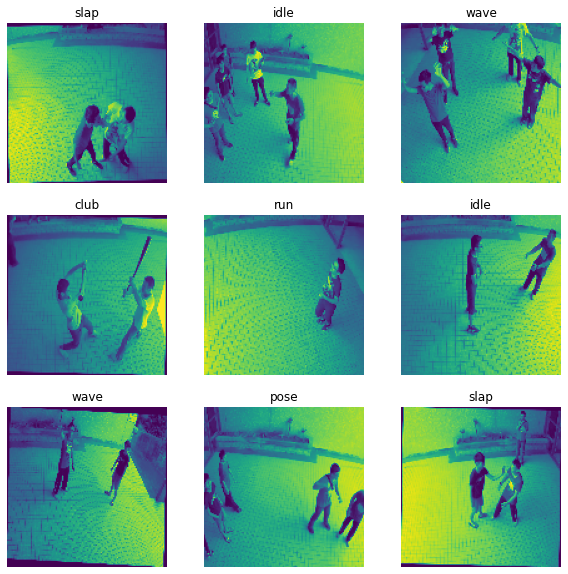

In [ ]:
image_batch, label_batch = next(iter(train_ds))
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().reshape(128,128))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

Se usa la funcionalidad de preprocesamiento de keras para escalar los pixeles y reescalar el tamaño de la imágen.

In [ ]:
from tensorflow.keras import layers

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(img_height, img_width), # Ajuste de dimensiones
  layers.experimental.preprocessing.Rescaling(1./255) # Normalización entre 0 y 1
])

# Red Convolucional
<p style="text-align: justify;">

La primera estrategia es plantear un modelo experimental con convoluciones, Maxpooling y Dropout, a entrenar sobre el data set inicial. Tomando en cuenta algunas recomendaciones para crear una red convolucional [towards data science](https://towardsdatascience.com/a-guide-to-an-efficient-way-to-build-neural-network-architectures-part-ii-hyper-parameter-42efca01e5d7)  se ha optado por crear una serie de filtros pequeños (3x3) para extraer la mayor cantidad de detalles en cada imagen, apoyados con un MaxPooling. Luego se añaden otros filtros cada vez más grandes (5x5 y 7x7) para poder abarcar una mayor área de la imagen y extraer elementos más generales. Todas estas capas convolucionales se apoyan con una función de activación ReLu. Posteriormente se pasa todala información procesada por las capas convolucionales a una red de una capa con 128 neuronas luego de aplanar los datos, apoyado con un Dropout para reducir la complejidad del cálculo y disminuir la posibilidad de un sobreajuste. Finalmente, se pasa la información a una capa de salida de 12 neuronas que determinará la categoría de la imagen.

<p>

In [ ]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

In [ ]:
num_classes = 12

model = tf.keras.Sequential([
  resize_and_rescale,
  #data_augmentation,
  Conv2D(64, 3, activation='relu'),
  MaxPooling2D(),
  Conv2D(64, 3, activation='relu'),
  MaxPooling2D(),
  Conv2D(32, 5, activation='relu'),
  MaxPooling2D(),
  Conv2D(32, 7, activation='relu'),
  MaxPooling2D(),
  Flatten(),
  Dense(128, activation='relu'),
  Dropout(0.5),
  Dense(12, activation='softmax')
])

Se compila el modelo. La función de pérdida elegida es la entropía cruzada y la métrica de evaluación la tasa de accuracy

In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

Se establecen metaparámetros de épocas y batch

In [ ]:
epoch = 50
batchs = 128

Se crea un callback que este monitoreando la pérdida y salve el mejor modelo en una ruta interna.

In [ ]:
from numpy.testing import assert_allclose
from keras.models import Sequential, load_model
from keras.callbacks import ModelCheckpoint
filepath = "/content/gdrive/MyDrive/Colab Notebooks/Diplomado_Inteligencia_Artificial/tmp/"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

Se entrena el modelo

In [ ]:
history=model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epoch, batch_size=batchs,  callbacks=callbacks_list)

Epoch 1/50
95/95 [==============================] - 1726s 18s/step - loss: 2.4124 - accuracy: 0.1340 - val_loss: 2.0535 - val_accuracy: 0.2821

Epoch 00001: loss improved from inf to 2.30342, saving model to /content/gdrive/MyDrive/Colab Notebooks/Diplomado_Inteligencia_Artificial/tmp/
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/Diplomado_Inteligencia_Artificial/tmp/assets
Epoch 2/50
95/95 [==============================] - 8s 89ms/step - loss: 1.9602 - accuracy: 0.3025 - val_loss: 1.4927 - val_accuracy: 0.4871

Epoch 00002: loss improved from 2.30342 to 1.83853, saving model to /content/gdrive/MyDrive/Colab Notebooks/Diplomado_Inteligencia_Artificial/tmp/
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/Diplomado_Inteligencia_Artificial/tmp/assets
Epoch 3/50
95/95 [==============================] - 8s 89ms/step - loss: 1.5778 - accuracy: 0.4436 - val_loss: 1.4094 - val_accuracy: 0.5245

Epoch 00003: loss improved from 1.83853 to

Se baja el modelo guardado y se continúa el entrenamiento con los pesos guardados.

In [ ]:
# load the model
new_model = tf.keras.models.load_model('/content/gdrive/MyDrive/Colaboratory/my_model.h5')
#assert_allclose(model.predict(train_ds), new_model.predict(train_ds))

In [ ]:
# fit the model
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
history=new_model.fit(train_ds, validation_data=val_ds, epochs=50, batch_size=128, callbacks=callbacks_list)

Epoch 1/50
95/95 [==============================] - 9s 90ms/step - loss: 0.3993 - accuracy: 0.8766 - val_loss: 0.3313 - val_accuracy: 0.8905

Epoch 00001: loss improved from inf to 0.39932, saving model to /content/gdrive/MyDrive/Colab Notebooks/Diplomado_Inteligencia_Artificial/tmp/
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/Diplomado_Inteligencia_Artificial/tmp/assets
Epoch 2/50
95/95 [==============================] - 8s 88ms/step - loss: 0.4790 - accuracy: 0.8432 - val_loss: 0.1619 - val_accuracy: 0.9466

Epoch 00002: loss did not improve from 0.39932
Epoch 3/50
95/95 [==============================] - 8s 88ms/step - loss: 0.2791 - accuracy: 0.9042 - val_loss: 0.1453 - val_accuracy: 0.9504

Epoch 00003: loss improved from 0.39932 to 0.27914, saving model to /content/gdrive/MyDrive/Colab Notebooks/Diplomado_Inteligencia_Artificial/tmp/
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/Diplomado_Inteligencia_Artificial/tmp/asse

In [ ]:
new_model.save('/content/gdrive/MyDrive/Colaboratory/my_model.h5')

In [ ]:
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 126, 126, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 32)        51232     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)       

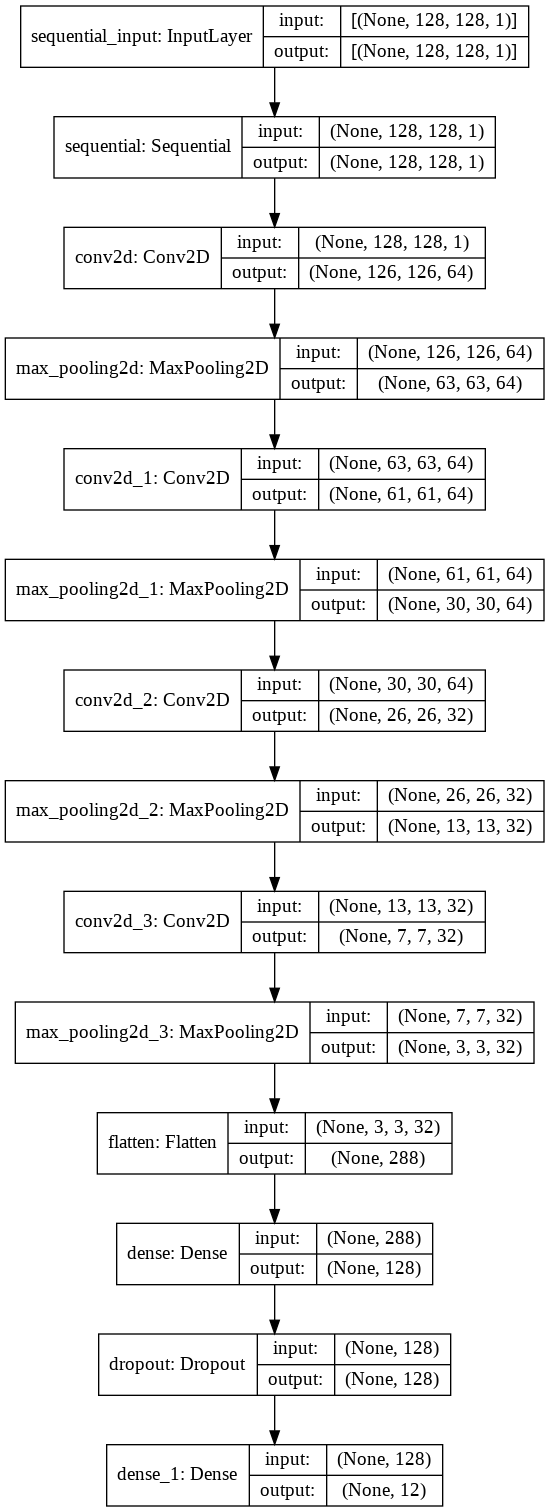

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(new_model, to_file='./mnist_dense.png', 
          show_shapes=True, show_dtype=False)

Una vez entrenado el modelo, lo evaluamos con los datos de validación y las imágenes que fueron eliminadas de la red. Los resultados son muy similes con un valor cercano al 94%. Un valor que no esta mal para ser sencilla y con pocos parámetros.

Como nota, no volveremos a usar los datos excluidos de la red para evaluar el modelo debido a que el proceso tarda mucho tiempo y los resultados son similares con respecto a los de validación.

In [ ]:
result = new_model.evaluate(val_ds) # Evaluación del modelo con los datos de validación

38/38 [==============================] - 639s 13s/step - loss: 0.2487 - accuracy: 0.9391


In [ ]:
result_test = new_model.evaluate(test_ds) # Evaluación del modelo con los datos que no vió la red

339/339 [==============================] - 5536s 16s/step - loss: 0.2625 - accuracy: 0.9358


In [ ]:
for name, value in zip(new_model.metrics_names, result):
    print(name, value)

loss 0.16030482947826385
accuracy 0.959700882434845


Se dibuja la función de pérdida y la métrica de ajuste. Se observa alto desempeño, cierta estabilidad y leve sobreajuste.

In [ ]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


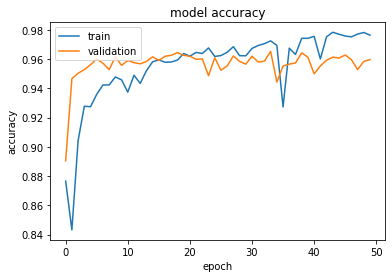

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


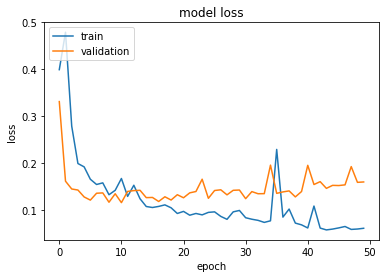

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('destination_path.eps', format='eps', dpi=1000)
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('destination_path1.eps', format='eps', dpi=1000)
plt.show()

Probando con alguna imágen al azar y una propia:

(-0.5, 127.5, 127.5, -0.5)

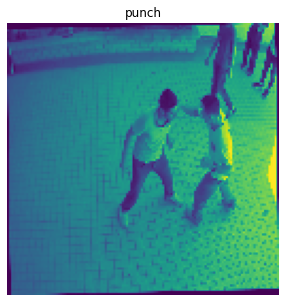

In [ ]:
j = np.random.randint(127) # 127 porque entra en batches de 128
image_test_batch, label_batch_test = next(iter(test_ds))
plt.figure(figsize=(5, 5))
plt.imshow(image_test_batch[j].numpy().reshape(128,128).astype("uint8"))
label = label_batch_test[j]
plt.title(class_names[label])
plt.axis("off")

In [ ]:
preds = new_model.predict(image_test_batch)

In [ ]:
print(preds.shape)

(128, 12)


In [ ]:
#mostrar vecto de probabilidades (resultado del softmax)
print(preds[j])

[8.0037760e-05 1.2017061e-04 9.5970842e-11 9.4138628e-08 5.5963629e-14
 4.5419380e-14 9.9979967e-01 5.5449378e-10 8.2133562e-09 1.5342776e-09
 1.9137554e-25 6.6859069e-18]


In [ ]:
# Calcular el ínidce máximo por filas
label_preds=np.argmax(preds,axis=1)
print("Cuántos label predichos:",label_preds.shape,'\n')
print("Predicciones:\n")
print(label_preds)

Cuántos label predichos: (128,) 

Predicciones:

[ 2  1  7  5  4 11  8  2  7 11  9  4  0  1  4  1  1  7  4 11  7  9  0  0
  3  2  4 11  0 11  2  0  6 11  8  4  2  4  5  2  9  3  3  7  7  7  5 10
  7 11 11  8  1 10  5 11  6  2 11  1  4  6  8 11  6  9  3  8  2  8  1  2
  2  7  7  1 10  4  7  0  0  9  3  3  7  6  2  7  3  3  1  0  4  2  9  7
 11  8  7  4  2  9 11  9 11 10  9  7  8 10  5  3  2  3  3  9  2  5  8  3
  6  8  9  3  5 10  3  5]


In [ ]:
print("Etiqueta predicha:",label_preds[j])

Etiqueta predicha: 6


Máquina vs Humano



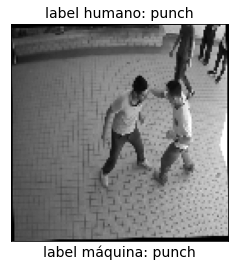

In [ ]:
print("Máquina vs Humano\n")
plt.imshow(image_test_batch[j,:,:,0],cmap='gray')
#plt.axis('off')
plt.title('label humano: ' + str(class_names[label]) ,fontsize=14)
plt.xlabel("label máquina: "+str(class_names[label_preds[j]]),fontsize=14)
plt.xticks([], [])
plt.yticks([], [])
plt.show()

Sin embargo se presentan algunos errores que veremos con mayor detalle a continuación:

In [ ]:
bad_pred=[]
for i in range (len(preds)):
    if label_preds[i]!=label_batch_test[i]:
        bad_pred.append(i)

bad_pred=np.array(bad_pred)

In [ ]:
print("Malas Predicciones:\n\n",bad_pred,'\n')
print("Cuántas: ",bad_pred.shape[0])

Malas Predicciones:

 [ 17  20  28  48  76  95 107] 

Cuántas:  7


Mala Predicción:



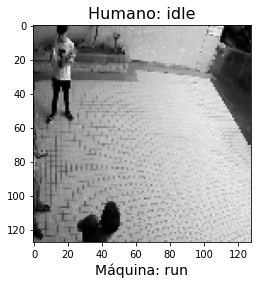

In [ ]:
azar_test= np.random.randint(len(bad_pred))
print("Mala Predicción:\n")

plt.title('Humano: ' +str(class_names[label_batch_test[bad_pred[azar_test]]]),fontsize=16)
plt.imshow(image_test_batch[bad_pred[azar_test],:,:,0],cmap='gray')
plt.xlabel("Máquina: "+str(class_names[np.argmax(preds[bad_pred[azar_test]])]),fontsize=14)
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix

print('Confusion Matrix:\n')
print(confusion_matrix(label_batch_test, label_preds),'\n')

print(classification_report(label_batch_test, label_preds))

Confusion Matrix:

[[ 7  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  9  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 15  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 14  0  0  0  1  0  0  0  0]
 [ 1  0  0  0 11  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  8  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  6  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 11  0  0  1  0]
 [ 0  0  0  0  0  0  0  0 10  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 11  0  0]
 [ 0  0  0  0  0  0  0  2  0  0  5  0]
 [ 0  0  0  0  0  0  0  2  0  0  0 14]] 

              precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        15
           3       1.00      0.93      0.97        15
           4       1.00      0.92      0.96        12
           5       1.00      1.00      1.00         8
           6       1.00      1.00      1.00         6
           7       0.69      0.92      0.79        12
           8       1.00

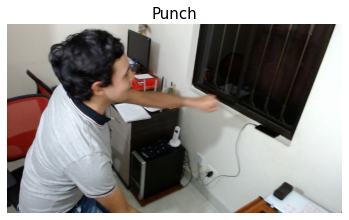

In [ ]:
from PIL import Image

# Path_local = '../Imagenes/mi_fotico.jpg

mi_fotico=Image.open("/content/gdrive/MyDrive/Colaboratory/mi_fotico.jpg")

# test_reduced and test_reduced_2 tienen la información invertida
#data_mi_fotico=(255-np.array(mi_fotico))/255.

# Para test_reduced_3
data_mi_fotico=(np.array(mi_fotico))/255.

plt.title('Punch',fontsize=15)
plt.imshow(data_mi_fotico)
plt.axis('off')
plt.show()



In [ ]:
mi_fotico = np.array(mi_fotico)
mi_fotico = tf.image.rgb_to_grayscale(mi_fotico)

  # Ajustar el tamaño de la imagen a 128 x 128 (shape(128,128,1))
mi_fotico=tf.image.resize(mi_fotico, [img_height, img_width])
mi_fotico=mi_fotico.numpy().reshape(1,128,128,1)

In [ ]:
predsreal = new_model.predict(mi_fotico)

In [ ]:
print(predsreal.shape)

(1, 12)


In [ ]:
# Calcular el ínidce máximo por filas
label_predsreal=np.argmax(predsreal,axis=1)
print("Cuántos label predichos:",label_predsreal.shape,'\n')
print("Predicciones:\n")
print(label_predsreal)

Cuántos label predichos: (1,) 

Predicciones:

[4]


In [ ]:
class_names[label_predsreal]

array(['kick'], dtype='<U8')

# Redes Preentrenadas

La segunda estrategia de modelación es usar transfer learning a partir de modelos preentrenados. Se utilizan 2 modelos del "estado del arte": VGG16 y ResNet. A cada modelo se le ensamblan (en reemplazo del layer final clasificatorio) yna pequeña arquitectura de red que se entrena con los nuevos datos, usando en el proceso los pesos preentrenados de la red original.

## Pre-entrenado ResNet50

Importamos las librerias necesarias para la red ResNet50

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import argparse

### Cargar imágenes en rgb

Estas redes fueron entrenadas para recibir imágenes con 3 canales, por esta razón no es posible ensayar con las imágenes a blanco y negro.

In [ ]:
val_size2 = int(image_count * 0.8)
train_ds2 = list_ds.skip(val_size2)
_ds2=list_ds.take(val_size2)
val_size2 = int(len(list(_ds2)) * 0.9)
val_ds2 = _ds2.skip(val_size2)
test_ds2=_ds2.take(val_size2)

In [ ]:
def get_labelResNet(file_path):
  # Convierte el path en una lista de componentes de la ruta
  parts = tf.strings.split(file_path, os.path.sep)
  # Construye la clase a partir del nombre del archivo (el nombre de la acción se encuentra en la tercera posición de atrás para delante del texto del nombre del archivo)
  one_hot = parts[-3] == class_names
  # codifica en enteros la etiqueta
  return tf.argmax(one_hot)

In [ ]:
def decode_imgResNet(img):
  # Convierte la cadena comprimida de caracteres en un 3Duint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)

  # Ajustar el tamaño de la imagen a 128 x 128
  return tf.image.resize(img, [img_height, img_width])

In [ ]:
def process_pathResNet(file_path):
  label = get_labelResNet(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_imgResNet(img)
  return img, label

In [ ]:
train_ds2 = train_ds2.map(process_pathResNet, num_parallel_calls=AUTOTUNE)
val_ds2 = val_ds2.map(process_pathResNet, num_parallel_calls=AUTOTUNE)
test_ds2 = test_ds2.map(process_pathResNet, num_parallel_calls=AUTOTUNE)

In [ ]:
for image, label in train_ds2.take(5):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (128, 128, 3)
Label:  8
Image shape:  (128, 128, 3)
Label:  4
Image shape:  (128, 128, 3)
Label:  10
Image shape:  (128, 128, 3)
Label:  8
Image shape:  (128, 128, 3)
Label:  6


In [ ]:
def configure_for_performanceResNet(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds2 = configure_for_performanceResNet(train_ds2)
val_ds2 = configure_for_performanceResNet(val_ds2)
test_ds2 = configure_for_performance(test_ds2)

### Cargar el modelo ResNet50

In [ ]:
# load the ResNet-50 network, ensuring the head FC layer sets are left
# off
baseModel =  tf.keras.applications.ResNet50(weights="imagenet", include_top=False,	input_tensor=Input(shape=(128, 128, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(3, 3))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(num_classes, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
modelResNet = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the training process
for layer in baseModel.layers:
	layer.trainable = False

94773248/94765736 [==============================] - 1s 0us/step


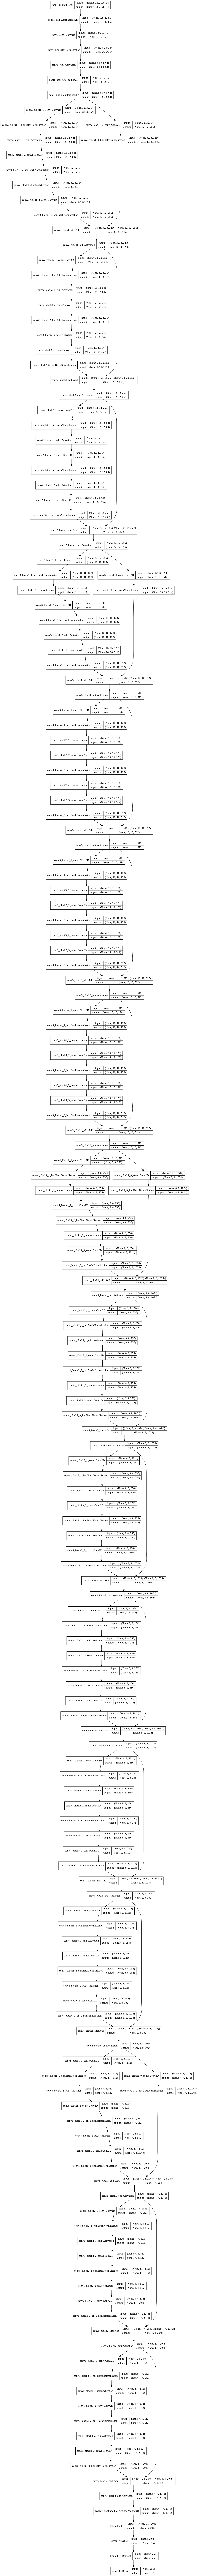

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(modelResNet, to_file='./mnist_dense.png', 
          show_shapes=True, show_dtype=False)

In [ ]:
modelResNet.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
# Se compila el modelo
print("[INFO] compiling model...")
modelResNet.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

historyResNet=modelResNet.fit(train_ds2, validation_data=val_ds2, epochs=epoch, batch_size=batchs)

"""
print("[INFO] training head...")
H = model.fit(
	x=trainAug.flow(train_ds, batch_size=32),
	steps_per_epoch=len(train_ds) // 32,
	validation_data=valAug.flow(val_ds),
	validation_steps=len(val_ds) // 32,
	epochs=epochs)
"""

[INFO] compiling model...
Epoch 1/50
95/95 [==============================] - 92s 898ms/step - loss: 2.1934 - accuracy: 0.3882 - val_loss: 0.7674 - val_accuracy: 0.7705
Epoch 2/50
95/95 [==============================] - 18s 187ms/step - loss: 0.9834 - accuracy: 0.6673 - val_loss: 0.5541 - val_accuracy: 0.8166
Epoch 3/50
95/95 [==============================] - 18s 187ms/step - loss: 0.7458 - accuracy: 0.7528 - val_loss: 0.4277 - val_accuracy: 0.8612
Epoch 4/50
95/95 [==============================] - 18s 185ms/step - loss: 0.6031 - accuracy: 0.7981 - val_loss: 0.3812 - val_accuracy: 0.8772
Epoch 5/50
95/95 [==============================] - 17s 184ms/step - loss: 0.4966 - accuracy: 0.8363 - val_loss: 0.3201 - val_accuracy: 0.8926
Epoch 6/50
95/95 [==============================] - 18s 186ms/step - loss: 0.4392 - accuracy: 0.8490 - val_loss: 0.2926 - val_accuracy: 0.9051
Epoch 7/50
95/95 [==============================] - 18s 186ms/step - loss: 0.3952 - accuracy: 0.8665 - val_loss: 0.2

'\nprint("[INFO] training head...")\nH = model.fit(\n\tx=trainAug.flow(train_ds, batch_size=32),\n\tsteps_per_epoch=len(train_ds) // 32,\n\tvalidation_data=valAug.flow(val_ds),\n\tvalidation_steps=len(val_ds) // 32,\n\tepochs=epochs)\n'

In [ ]:
#modelResNet.save('/content/gdrive/MyDrive/Colaboratory/modelResnet.h5')

In [ ]:
modelResNet = tf.keras.models.load_model('/content/gdrive/MyDrive/Colaboratory/modelResnet.h5')


Al correr el modelo con los datos de validación tenemos un accuracy del 95,16%, algo mayor que el modelo previo usando únicamente convoluciones, aunque no es un gran salto.

In [ ]:
resultResNet = modelResNet.evaluate(val_ds2) # Evaluación del modelo con los datos de validación

38/38 [==============================] - 292s 8s/step - loss: 0.1596 - accuracy: 0.9516


Se dibuja la función de pérdida y la métrica de ajuste. Se observa alto desempeño, cierta estabilidad y leve sobreajuste.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


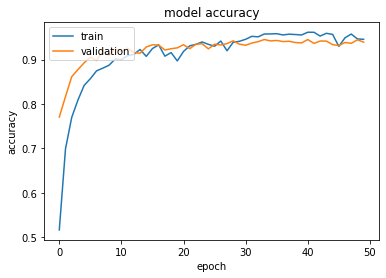

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


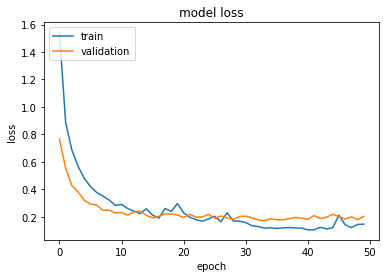

In [ ]:
plt.plot(historyResNet.history['accuracy'])
plt.plot(historyResNet.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('destination_path.eps', format='eps', dpi=1000)
plt.show()
# summarize history for loss
plt.plot(historyResNet.history['loss'])
plt.plot(historyResNet.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('destination_path1.eps', format='eps', dpi=1000)
plt.show()

(-0.5, 127.5, 127.5, -0.5)

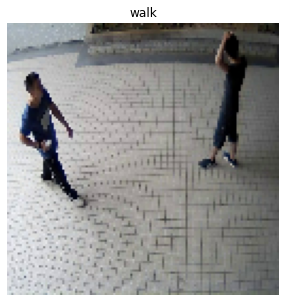

In [ ]:
j = np.random.randint(127) # 127 porque entra en batches de 128
image_test_batchResNet, label_batch_testResNet = next(iter(test_ds2))
plt.figure(figsize=(5, 5))
plt.imshow(image_test_batchResNet[j].numpy().astype("uint8"))
label = label_batch_testResNet[j]
plt.title(class_names[label])
plt.axis("off")

In [ ]:
preds = modelResNet.predict(image_test_batchResNet)

In [ ]:
print(preds.shape)

(128, 12)


In [ ]:
#mostrar vecto de probabilidades (resultado del softmax)
print(preds[j])

[1.0627326e-17 8.7373620e-19 4.4054059e-07 1.5057045e-13 8.9671287e-15
 1.1826757e-20 4.5274341e-14 1.4824384e-04 3.2385203e-17 7.7016171e-10
 9.9985135e-01 2.8906030e-10]


In [ ]:
# Calcular el ínidce máximo por filas
label_preds=np.argmax(preds,axis=1)
print("Cuántos label predichos:",label_preds.shape,'\n')
print("Predicciones:\n")
print(label_preds)

Cuántos label predichos: (128,) 

Predicciones:

[ 4  7  0 10  3  3  9  0  2  2  7  2  7 11  1 11  6  3 10  1  7  0  2  9
  3  3  4  9 11 10 11  9 11  3  3  3 11  9 11  3  6 10  2 11  6  8  9  3
  9  4  9  9  8  4  9  1  9  7  0  7  0  5  4  3  7  4  3  7  1  0 11  7
 10  6 10  2  9 11  2 10  9  4  3 10  8 11 11  8  1 11  6 11  3  6  2 11
 11 10  3  3  2 11 10  7  6  1 10 10  7  5  3 11 10  3  9  3  3 11  5  9
 11  0  9  7  5  7  2  8]


In [ ]:
print("Etiqueta predicha:",label_preds[j])

Etiqueta predicha: 10


Máquina vs Humano



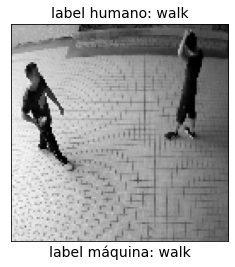

In [ ]:
print("Máquina vs Humano\n")
plt.imshow(image_test_batchResNet[j,:,:,0], cmap="gray")
#plt.axis('off')
plt.title('label humano: ' + str(class_names[label]) ,fontsize=14)
plt.xlabel("label máquina: "+str(class_names[label_preds[j]]),fontsize=14)
plt.xticks([], [])
plt.yticks([], [])
plt.show()

In [ ]:
bad_pred=[]
for i in range (len(preds)):
    if label_preds[i]!=label_batch_testResNet[i]:
        bad_pred.append(i)

bad_pred=np.array(bad_pred)

In [ ]:
print("Malas Predicciones:\n\n",bad_pred,'\n')
print("Cuántas: ",bad_pred.shape[0])

Malas Predicciones:

 [ 62  64  67  72  81  83  92  99 100 123] 

Cuántas:  10


Mala Predicción:



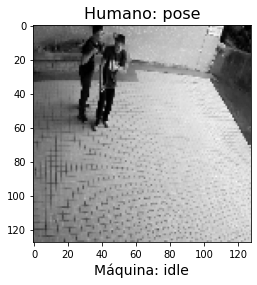

In [ ]:
azar_test= np.random.randint(len(bad_pred))
print("Mala Predicción:\n")

plt.title('Humano: ' +str(class_names[label_batch_testResNet[bad_pred[azar_test]]]),fontsize=16)
plt.imshow(image_test_batchResNet[bad_pred[azar_test],:,:,0], cmap="gray")
plt.xlabel("Máquina: "+str(class_names[np.argmax(preds[bad_pred[azar_test]])]),fontsize=14)
plt.show()

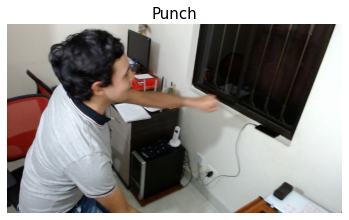

In [ ]:
from PIL import Image

# Path_local = '../Imagenes/mi_fotico.jpg

mi_fotico=Image.open("/content/gdrive/MyDrive/Colaboratory/mi_fotico.jpg")

# test_reduced and test_reduced_2 tienen la información invertida
#data_mi_fotico=(255-np.array(mi_fotico))/255.

# Para test_reduced_3
data_mi_fotico=(np.array(mi_fotico))/255.

plt.title('Punch',fontsize=15)
plt.imshow(data_mi_fotico)
plt.axis('off')
plt.show()


In [ ]:
mi_fotico = np.array(mi_fotico)

  # Ajustar el tamaño de la imagen a 128 x 128 (shape(128,128,1))
mi_fotico=tf.image.resize(mi_fotico, [img_height, img_width])
mi_fotico=mi_fotico.numpy().reshape(1,128,128,3)

In [ ]:
predsreal = modelResNet.predict(mi_fotico)

In [ ]:
# Calcular el ínidce máximo por filas
label_predsreal=np.argmax(predsreal,axis=1)
print("Cuántos label predichos:",label_predsreal.shape,'\n')
print("Predicciones:\n")
print(label_predsreal)

Cuántos label predichos: (1,) 

Predicciones:

[4]


## Preentrenado VGG16

Se repite exáctamente el mismo ejercicio con otra nueva red preentrenada

In [ ]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.models import Model

In [ ]:
baseModel =  VGG16(include_top=False,	input_tensor=Input(shape=(128, 128, 3)))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(3, 3))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(num_classes, activation="softmax")(headModel)
modelVGG16 = Model(inputs=baseModel.input, outputs=headModel)
for layer in baseModel.layers:
	layer.trainable = False

58892288/58889256 [==============================] - 0s 0us/step


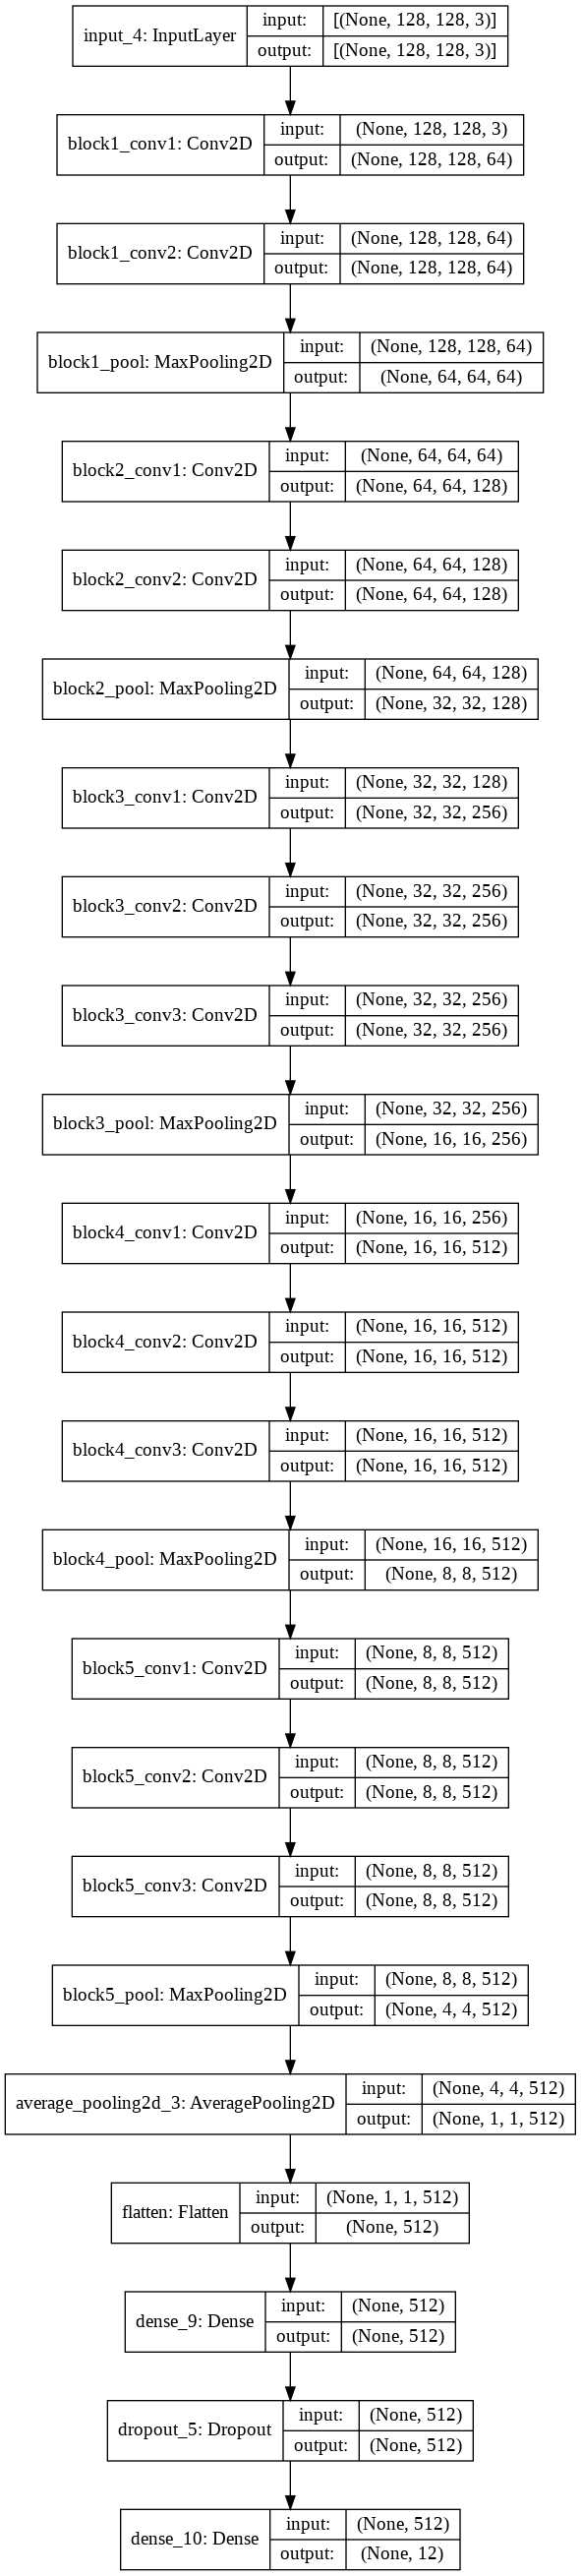

In [ ]:
plot_model(modelVGG16, to_file='./mnist_dense.png', 
          show_shapes=True, show_dtype=False)

In [ ]:
modelVGG16.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0   

In [ ]:
"""
trainAug = ImageDataGenerator(
	rotation_range=30,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")
valAug = ImageDataGenerator()
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean
valAug.mean = mean
"""

'\ntrainAug = ImageDataGenerator(\n\trotation_range=30,\n\tzoom_range=0.15,\n\twidth_shift_range=0.2,\n\theight_shift_range=0.2,\n\tshear_range=0.15,\n\thorizontal_flip=True,\n\tfill_mode="nearest")\nvalAug = ImageDataGenerator()\nmean = np.array([123.68, 116.779, 103.939], dtype="float32")\ntrainAug.mean = mean\nvalAug.mean = mean\n'

In [ ]:
print("[INFO] compiling model...")
modelVGG16.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
historyVGG16=modelVGG16.fit( train_ds2, validation_data=val_ds2, epochs=epoch, batch_size=batchs)

"""
print("[INFO] training head...")
H = model.fit(
	x=trainAug.flow(train_ds, batch_size=32),
	steps_per_epoch=len(train_ds) // 32,
	validation_data=valAug.flow(val_ds),
	validation_steps=len(val_ds) // 32,
	epochs=epochs)
"""

[INFO] compiling model...
Epoch 1/50
95/95 [==============================] - 33s 274ms/step - loss: 6.5555 - accuracy: 0.3750 - val_loss: 0.7055 - val_accuracy: 0.7765
Epoch 2/50
95/95 [==============================] - 21s 217ms/step - loss: 0.9220 - accuracy: 0.7027 - val_loss: 0.4546 - val_accuracy: 0.8554
Epoch 3/50
95/95 [==============================] - 21s 222ms/step - loss: 0.6248 - accuracy: 0.7993 - val_loss: 0.3717 - val_accuracy: 0.8758
Epoch 4/50
95/95 [==============================] - 21s 225ms/step - loss: 0.4831 - accuracy: 0.8399 - val_loss: 0.3230 - val_accuracy: 0.8934
Epoch 5/50
95/95 [==============================] - 22s 228ms/step - loss: 0.3745 - accuracy: 0.8743 - val_loss: 0.2689 - val_accuracy: 0.9123
Epoch 6/50
95/95 [==============================] - 22s 231ms/step - loss: 0.3143 - accuracy: 0.8913 - val_loss: 0.2426 - val_accuracy: 0.9202
Epoch 7/50
95/95 [==============================] - 22s 230ms/step - loss: 0.2629 - accuracy: 0.9117 - val_loss: 0.2

'\nprint("[INFO] training head...")\nH = model.fit(\n\tx=trainAug.flow(train_ds, batch_size=32),\n\tsteps_per_epoch=len(train_ds) // 32,\n\tvalidation_data=valAug.flow(val_ds),\n\tvalidation_steps=len(val_ds) // 32,\n\tepochs=epochs)\n'

In [ ]:
# modelVGG16.save('/content/gdrive/MyDrive/Colaboratory/modelVGG16.h5')


In [ ]:
modelVGG16 = tf.keras.models.load_model('/content/gdrive/MyDrive/Colaboratory/modelVGG16.h5')


El modelo preentrenado VGG16 fue el que mejor comportamiento tuvo con un accuracy del 96,28%. Sin embargo, no dista mucho del 93.54% del modelo básico convolucional.

In [ ]:
resultVGG16 = modelVGG16.evaluate(val_ds2) # Evaluación del modelo con los datos de validación

38/38 [==============================] - 18s 301ms/step - loss: 0.1426 - accuracy: 0.9628


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


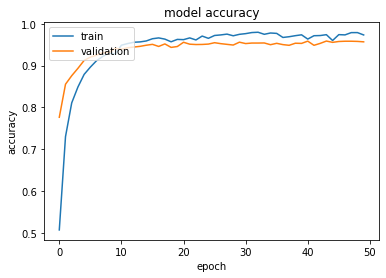

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


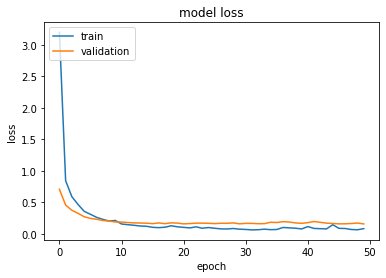

In [ ]:
plt.plot(historyVGG16.history['accuracy'])
plt.plot(historyVGG16.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('destination_path.eps', format='eps', dpi=1000)
plt.show()
# summarize history for loss
plt.plot(historyVGG16.history['loss'])
plt.plot(historyVGG16.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('destination_path1.eps', format='eps', dpi=1000)
plt.show()

(-0.5, 127.5, 127.5, -0.5)

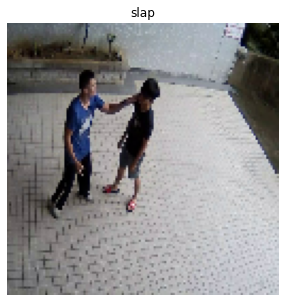

In [ ]:
j = np.random.randint(127) # 127 porque entra en batches de 128
image_test_batchVGG16, label_batch_testVGG16 = next(iter(test_ds2))
plt.figure(figsize=(5, 5))
plt.imshow(image_test_batchVGG16[j].numpy().astype("uint8"))
label = label_batch_testVGG16[j]
plt.title(class_names[label])
plt.axis("off")

In [ ]:
preds = modelVGG16.predict(image_test_batchVGG16)

In [ ]:
print(preds.shape)

(128, 12)


In [ ]:
#mostrar vecto de probabilidades (resultado del softmax)
print(preds[j])

[4.8739616e-17 5.3191011e-12 6.0071454e-15 3.4737976e-12 6.7421524e-10
 2.5592091e-13 1.0049866e-08 5.2839247e-11 1.3630456e-10 1.0000000e+00
 3.6771587e-13 3.9904480e-15]


In [ ]:
# Calcular el ínidce máximo por filas
label_preds=np.argmax(preds,axis=1)
print("Cuántos label predichos:",label_preds.shape,'\n')
print("Predicciones:\n")
print(label_preds)

Cuántos label predichos: (128,) 

Predicciones:

[ 8  9 10 10  7  2  5  2  4  5 10  2  9  0  2  9  8  6  9  8  3  7  3  7
  4  2 10  4  3 10 10 11  4  8  3  9  2 10  0  4  7  2 11  9  5  8 11  2
  3  6  7  3  3  7  7  0  8 10  3  9  3  6 10  1  7  9  8  5  4  6  4  0
  5  6 11  7  9  0  6  7  8  5  2  5  4  7  0 10  0  7  3  0  0  9  5 10
  7  8  3 11  7  6  8  5  7  4  8  9  0  8  2 11  7  0  3  5  6  7 11  7
  1  0  3  2  8 11  9  6]


In [ ]:
print("Etiqueta predicha:",label_preds[j])

Etiqueta predicha: 9


Máquina vs Humano



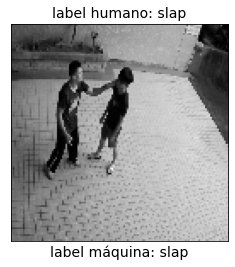

In [ ]:
print("Máquina vs Humano\n")
plt.imshow(image_test_batchVGG16[j,:,:,0],cmap="gray")
#plt.axis('off')
plt.title('label humano: ' + str(class_names[label]) ,fontsize=14)
plt.xlabel("label máquina: "+str(class_names[label_preds[j]]),fontsize=14)
plt.xticks([], [])
plt.yticks([], [])
plt.show()

In [ ]:
bad_pred=[]
for i in range (len(preds)):
    if label_preds[i]!=label_batch_testVGG16[i]:
        bad_pred.append(i)

bad_pred=np.array(bad_pred)

In [ ]:
print("Malas Predicciones:\n\n",bad_pred,'\n')
print("Cuántas: ",bad_pred.shape[0])

Malas Predicciones:

 [ 24  86  87 100] 

Cuántas:  4


Mala Predicción:



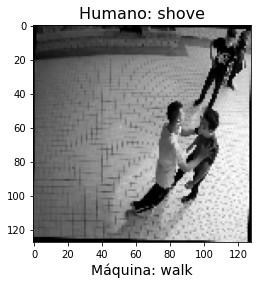

In [ ]:
azar_test= np.random.randint(len(bad_pred))
print("Mala Predicción:\n")

plt.title('Humano: ' +str(class_names[label_batch_testResNet[bad_pred[azar_test]]]),fontsize=16)
plt.imshow(image_test_batchResNet[bad_pred[azar_test],:,:,0], cmap="gray")
plt.xlabel("Máquina: "+str(class_names[np.argmax(preds[bad_pred[azar_test]])]),fontsize=14)
plt.show()

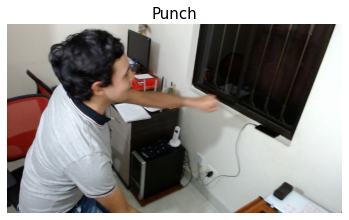

In [ ]:
plt.title('Punch',fontsize=15)
plt.imshow(data_mi_fotico)
plt.axis('off')
plt.show()

In [ ]:
predsreal = modelVGG16.predict(mi_fotico)

In [ ]:
# Calcular el ínidce máximo por filas
label_predsreal=np.argmax(predsreal,axis=1)
print("Cuántos label predichos:",label_predsreal.shape,'\n')
print("Predicciones:\n")
print(label_predsreal)

Cuántos label predichos: (1,) 

Predicciones:

[8]


In [ ]:
class_names[label_predsreal]

array(['shove'], dtype='<U8')

# Conclusión:

